# Load and Visualize Subject-Specific ROI Masks and Load the Trial IDs of the Presentation of shared1000 Image IDs - Preparation of the pRF Modeling 

This notebook aims to load and visualize the ROI masks of the NSD participants (*N*=8) to perform pRF modeling on the fMRI responses of the NSD participants (*N*=8) by Allen et al. (2022). It uses parts of the existing nsd-static-saliency project, published on Github (https://github.com/hrdkbhatnagar/nsd-static-saliency)

I. According to the selected subject number:  
II. It should load a list of the shared1000 Id  
III. Map the NSD image Ids to the trial Ids stored in nsd_stim_info_df_all dataframe
Prepartion of the pRF modeling 
1. Exploring the subject-specific angle data file (loaded from the NSD dataset), calculating the mid_vox 
2. Load the ROI masks from the NSD dataset 
3. Load pRF (eccentricity and angle) data and mask them with the subject-specific visual cortex masks
4. Save subject-specific ROI masks to disk
5. Visualizations of the relationship between the angle_data (polar angle) and the eccentricity. 
6. Function defintion load_prf_data 

Written by Lisa Heinemann  
Last edited: 19/05/2025

In [ ]:
# Imports 
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import csv
import h5py
from typing import Union
import nibabel as nib

import nilearn
from nilearn import image
from nilearn import plotting
from nilearn.image import math_img
# From nilearn.masking import apply_mask
from nilearn.maskers import NiftiMasker

# To load the masks 
from nilearn.input_data import NiftiMasker
import h5py
from typing import Union, List
import pickle
import builtins

import seaborn as sns

# For multiprocessing save_roi_masks to disk - so that all ROI masks can be processed quickly 
import multiprocessing as mp
from multiprocessing import Pool

# I. Set the subject number. 

In [ ]:
# TODO: Set the subject number to the desired subject of the NSD dataset (N= 8)
sub_num = 6

In [4]:
# Set Base Directory I for the Ground truth eye tracking data 
############################################################################################
# Create a Path object for the base directory
# TODO: Change to the correct Path. Decide wether to use the private or public path.
#base_dir = Path('~/saliency-nsd-priv').expanduser()

# # Create a Path object for the base directory pub
# TODO: Change to the correct Path.
base_dir = Path('/gpfs01/bartels/group/lheinemann/saliency-nsd-pub').expanduser()

# Check if the base directory exists with an assert 
assert base_dir.exists(), f'{base_dir} does not exist'
# Print the base directory
print(base_dir)

# Combine paths to create new Path objects for the data directory and the save directory

# Path to the concatenated DataFrame 'df_expanded_data_subjs_concatenated_all.csv' containing all experimental data
# One line represents one fixation of one subject in the DataFrame 
data_dir = base_dir/ 'data/preprocessed/df_expanded_data_subjs_concatenated_all.csv'

# To load the actual jpg images responding to their name stored in img_id in the dataframe 
img_dir = base_dir /'stimuli/shared1000'

# The fixation maps are stored in the save_dir
save_dir = base_dir / 'data/fixation_and_saliency_maps'

# Path to where the saliency maps (based on first fixations only) are stored
salmaps_1st_path = base_dir / 'data/fixation_and_saliency_maps/saliency_map_all_and_first_fixations.h5'

# Add hdf5 file path to store the values of the saliency maps
hdf5_file_path_all_and_first_fixations = save_dir / 'saliency_map_all_and_first_fixations.h5'

# Check if the data and save directories exist with assert statements, if not assertion error is raised
assert data_dir.exists(), f'{data_dir} does not exist'
assert save_dir.exists(), f'{save_dir} does not exist'
assert img_dir.exists(), f'{img_dir} does not exist'

# Debug check: Print statement of path 
print(data_dir)
print(save_dir)
print(img_dir)
print(hdf5_file_path_all_and_first_fixations)

# Print the working directory to double check: should be /gpfs01/bartels/user/lheinemann/saliency-nsd/code/code_analysis_saliency-nsd/1_data-preprocessing/creation_of_dataframes
print (os.getcwd())


/gpfs01/bartels/group/lheinemann/saliency-nsd-pub
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/preprocessed/df_expanded_data_subjs_concatenated_all.csv
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/stimuli/shared1000
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/saliency_map_all_and_first_fixations.h5
/gpfs01/bartels/user/lheinemann/nsd-static-saliency/scripts


Second path directions for the files that need to be loaded from the NSD dataset directory. 

In [5]:
# Set roots relative to the base_dir to gain access to the NSD Dataset, 

# TODO: Optional? Uncomment if needed
# COCO_ROOT = '/gpfs01/bartels/group/hbhatnagar/coco/panoptic_annotations_trainval2017'
base_dir_nsd = Path('/gpfs01/bartels/group/nsd_dataset')
############################################################################################################

NSD_DATA_ROOT  = base_dir_nsd / 'nsddata'
STIM_ROOT  = NSD_DATA_ROOT / 'stimuli/nsd/'


stim_file = STIM_ROOT / 'nsd_stimuli.hdf5'
shared1000_file = STIM_ROOT / 'shared1000.tsv'
exp_design_file = NSD_DATA_ROOT / 'experiments/nsd/nsd_expdesign.mat'
nsd_stiminfo_file = NSD_DATA_ROOT / 'experiments/nsd/nsd_stim_info_merged.csv'

print(nsd_stiminfo_file)
DATA_PATH = Path('/gpfs01/bartels/user/lheinemann/nsd-static-saliency/data')
print(DATA_PATH)

# Select the fMRT with the func1pt8mm for faster execution 
#PRF_PATH = base_dir_nsd / f'ppdata/subj0{sub_num}/func1pt8mm/'
# TODO: Change if needed, however, the prf_angle.nii.gz file could not be loaded for the 1.8mm data even though these files should consist in the folder 
PRF_PATH = base_dir_nsd / f'nsddata_betas/ppdata/subj0{sub_num}/func1pt8mm/'
print(PRF_PATH)
PRF_MASKS_PATH = NSD_DATA_ROOT / f'ppdata/subj0{sub_num}/func1pt8mm/'

# Regions of Interest Path 
ROI_PATH = NSD_DATA_ROOT/ 'ppdata/'

#ROI_PATH = NSD_ROOT/ 'ppdata/'
DEVICE = 'cpu'

/gpfs01/bartels/group/nsd_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.csv
/gpfs01/bartels/user/lheinemann/nsd-static-saliency/data
/gpfs01/bartels/group/nsd_dataset/nsddata_betas/ppdata/subj06/func1pt8mm


# II. Load the tsv file of Shared1000 - NSD images 

In [6]:
#Load the tsv file shared1000.tsv file containing the different nsdids of the images that were shown to all participants (*N*=8) to a list and name the first row nsd_id

# Initialize an empty list to store the data
shared1000_list = []

# Open and read the TSV file
with open(shared1000_file, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        shared1000_list.append(int(row[0]))  # Remove the storing of the values with brackets and apostrophes to store the values as integers

# Rename the first column to 'nsd_id'
#shared1000_list[0][0] = 'nsd_id'

# Print the first few rows to verify
print(shared1000_list[:5])


# Remember Python starts with zero-based indexing

[2951, 2991, 3050, 3078, 3147]


In [7]:
# Define the all rois

rois = [
    "v1", "v2", "v3", "v4",
    "ofa", "ffa1", "ffa2", "mtl_faces", "atl",
    "eba", "fba1", "fba2", "mtl_bodies",
    "opa", "ppa", "rsc",
    "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",
    "vo1", "vo2", "phc1", "phc2", "mst", "hmt",
    "lo2", "lo1", "v3b", "v3a", "ips0", "ips1",
    "ips2", "ips3", "ips4", "ips5", "spl1", "fef"
]

# In total 39 ROIs - and later in the code corresponding masks - even though for mtl_words and mtl_faces the masks could
# not be created for subject 1-4

# III. Load the nsd_stim_info_df_all. csv file containing all experiment information of the NSD dataset "nsd_stim_info_df_all".  

- Then, filter the rows where shared1000 is True, keeping only the entries where an NSD image was presented. Save this filtered data as nsd_stim_info_df_filtered. Next, update the NSD IDs to be 1-based indexed (instead of 0-based), and store the result in nsd_stim_info_df_correctIndex

- And reduce the dataframe columns to the relevant information and convert it to a NumPY Array "nsd_coco_array"

In [8]:
# Load the nsd_stim_info_merged.csv file containing the information about the NSD images in a DataFrame 
nsd_stim_info_df_all = pd.read_csv(nsd_stiminfo_file)

# Print the first 5 rows of the nsd_stim_info_merged.csv file
# nsd_stim_info_df_all.head()

# The name of the nsdIds starts with 0. Howver nsdId 0 is not in the shared1000.tsv file. Therefore this does not need to interest us. 

Only load the rows of the nsd_stim_info_merged.csv where the value of shared1000 is true.

 Information: Keep in mind that the NSD Ids are 0-based indexed and stored in the nsd_stim_info_merged.csv file, but 1-based indexed in the shared1000 list. Therefore, the values of the nsdIds in the shared1000.tsv file need to be added by one to find the corresponding nsdId in the nsd_stim_info_merged.csv file.

(e.g. nsdId in tsv file 2951 is nsdId 2950 in nsd_stim_info_merged.csv file)   

In [ ]:
# Extract rows from nsd_stim_info_df_all where shared1000 is true and store them in a list

# Filter the rows where shared1000 is true
nsd_stim_info_df_filtered = nsd_stim_info_df_all[nsd_stim_info_df_all['shared1000'] == True]

# Print the first 5 rows of the filtered DataFrame to verify
nsd_stim_info_df_filtered.head()

# Keep in mind that the nsdIds are 0-based indexed. Therefore the values of the nsdIds in the shared1000.tsv file need to be subtracted by one to find the corresponding nsdId in the nsd_stim_info_merged.csv file.
# (e.g. nsdId in tsv file 2951 is nsdId 2950 in nsd_stim_info_merged.csv file) 

############################################################################################
##################### Discover the ranges of the DataFrame #################################

# Print the dimensions of the filtered DataFrame
print(nsd_stim_info_df_filtered.shape)

# Print the first 5 rows of the filtered DataFrame
nsd_stim_info_df_filtered.head()


(1000, 41)


,Unnamed: 0,cocoId,cocoSplit,cropBox,loss,nsdId,flagged,BOLD5000,shared1000,subject1,...,subject5_rep2,subject6_rep0,subject6_rep1,subject6_rep2,subject7_rep0,subject7_rep1,subject7_rep2,subject8_rep0,subject8_rep1,subject8_rep2
2950,2950,262145,train2017,"(0, 0, 0.16640625, 0.16640625)",0.09375,2950,False,True,True,1,...,27566,2616,9716,27566,2616,9716,27566,2616,9716,27566
2990,2990,262239,train2017,"(0, 0, 0.1671875, 0.1671875)",0.10000,2990,False,True,True,1,...,27711,18458,18697,27711,18458,18697,27711,18458,18697,27711
3049,3049,262414,train2017,"(0, 0, 0.125, 0.125)",0.00000,3049,False,True,True,1,...,6697,6299,6448,6697,6299,6448,6697,6299,6448,6697
3077,3077,524646,train2017,"(0, 0, 0.1671875, 0.1671875)",0.00000,3077,False,True,True,1,...,4537,4289,4515,4537,4289,4515,4537,4289,4515,4537
3146,3146,262690,train2017,"(0, 0, 0.16640625, 0.16640625)",0.00000,3146,False,True,True,1,...,26807,8087,8443,26807,8087,8443,26807,8087,8443,26807


Reduce the DataFrame to the neccessary size. So only keep the COCOID, the trial ID and make a numpy array (nsd_coco_array) out of this information.  

In [ ]:
# Load the nsd_img_0based values from the filtered DataFrame to a list
nsd_img_0based = nsd_stim_info_df_filtered['nsdId'] 

# Convert the string of the nsdImg to an integer so that it can be added by 1
nsd_img_0based = nsd_img_0based.astype(int)

# Add 1 to the integer to get the correct nsdId
nsd_img_1based = nsd_img_0based + 1

# Convert the integer of the correct nsd back to a string 
nsd_img_1based = nsd_img_1based.astype(str)

# Print the result to verify
print(nsd_img_1based[:5])

# Add the new column to the DataFrame
nsd_stim_info_df_filtered['nsdId_1based'] = nsd_img_1based

# Reduce the DataFrame to the neccessary size. So only keep the COCOID, the nsdId+1 and make a numpy array out of this information. 
nsd_stim_info_df_correctIndex = nsd_stim_info_df_filtered[['nsdId_1based', 'cocoId']]

# Convert the reduced DataFrame to a NumPy array
nsd_coco_array= nsd_stim_info_df_correctIndex.to_numpy()

# Print the NumPy array to verify
print(nsd_coco_array[:5])


2950    2951
2990    2991
3049    3050
3077    3078
3146    3147
Name: nsdId, dtype: object
[['2951' 262145]
 ['2991' 262239]
 ['3050' 262414]
 ['3078' 524646]
 ['3147' 262690]]


/tmp/ipykernel_2929844/4109228835.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsd_stim_info_df_filtered['nsdId_1based'] = nsd_img_1based


### Test printing and saving of the nsd_stim_df_filterd and nsd_stim_info_ds_correctIndex files. 

In [ ]:
# Print the filtered DataFrame to verify the new colum nsdId_1based is now printed at the end of the DataFrame
nsd_stim_info_df_filtered.head()

# Save the filtered DataFrame to a CSV file in the save directory
#nsd_stim_info_df_filtered.to_csv(save_dir / 'nsd_stim_info_shared1000.csv', index=False)

# Save the filtered DataFrame to a CSV file in the working directory
nsd_stim_info_df_filtered.to_csv('nsd_stim_info_shared1000.csv', index=False)

# Print the second filtered DataFrame to verify that nsdId_1based and cocoId appear together in each row as an overview
nsd_stim_info_df_correctIndex.head()

# Save the reduced DataFrame to a CSV file in the save directory
#nsd_stim_info_df_filtered2.to_csv(save_dir / 'nsd_stim_info_shared1000_correctIndex.csv', index=False)

# Save the reduced DataFrame to a CSV file in the working directory
nsd_stim_info_df_correctIndex.to_csv('nsd_stim_info_shared1000_correctIndex.csv', index=False)


### The NumPy array 'nsd_coco_array' stores the classification of NSD ID and the corresponding COCO ID. 

In [12]:
# However, values of NSD Ids and Coco Ids are also stored in the nsd_coco_array, which can be easier accessed. 

# Print the first 5 rows of the NumPy array to verify
print(nsd_coco_array[:5])


[['2951' 262145]
 ['2991' 262239]
 ['3050' 262414]
 ['3078' 524646]
 ['3147' 262690]]


### Creation of a list of the trial ids relative to a certain image id in the nsd_stim_info_df_correctIndex

In [ ]:
# Create an array of trial IDs for the distinct image repetitions, along with their corresponding trial IDs

# Load the nsd_img_0based values from the filtered DataFrame to a list
nsd_img_1based = nsd_stim_info_df_filtered['nsdId']

In [14]:
# Now make a list of the trial ids relative to a certain image id, row
# Initialize an empty list to store the data
trial_ids = []

nsd_stim_info_df_filtered3 = nsd_stim_info_df_filtered[['nsdId_1based','cocoId', 'subject1_rep0', 'subject1_rep1', 'subject1_rep2', 'subject2_rep0','subject2_rep1', 'subject2_rep2', 'subject3_rep0', 'subject3_rep1', 'subject3_rep2', 'subject4_rep0', 'subject4_rep1', 'subject4_rep2', 'subject5_rep0', 'subject5_rep1', 'subject5_rep2', 'subject6_rep0', 'subject6_rep1', 'subject6_rep2', 'subject7_rep0', 'subject7_rep1', 'subject7_rep2', 'subject8_rep0', 'subject8_rep1', 'subject8_rep2']]

# Convert the reduced DataFrame to a NumPy array
nsdId_shared100_trialId_array = nsd_stim_info_df_filtered3.to_numpy()

# Print the NumPy array to verify
print(nsdId_shared100_trialId_array[:10])


[['2951' 262145 2616 9716 27566 2616 9716 27566 2616 9716 27566 2616 9716
  27566 2616 9716 27566 2616 9716 27566 2616 9716 27566 2616 9716 27566]
 ['2991' 262239 18458 18697 27711 18458 18697 27711 18458 18697 27711
  18458 18697 27711 18458 18697 27711 18458 18697 27711 18458 18697 27711
  18458 18697 27711]
 ['3050' 262414 6299 6448 6697 6299 6448 6697 6299 6448 6697 6299 6448
  6697 6299 6448 6697 6299 6448 6697 6299 6448 6697 6299 6448 6697]
 ['3078' 524646 4289 4515 4537 4289 4515 4537 4289 4515 4537 4289 4515
  4537 4289 4515 4537 4289 4515 4537 4289 4515 4537 4289 4515 4537]
 ['3147' 262690 8087 8443 26807 8087 8443 26807 8087 8443 26807 8087 8443
  26807 8087 8443 26807 8087 8443 26807 8087 8443 26807 8087 8443 26807]
 ['3158' 584 1125 7990 8592 1125 7990 8592 1125 7990 8592 1125 7990 8592
  1125 7990 8592 1125 7990 8592 1125 7990 8592 1125 7990 8592]
 ['3165' 605 11592 17581 17602 11592 17581 17602 11592 17581 17602 11592
  17581 17602 11592 17581 17602 11592 17581 17602 1159

In [ ]:
# Now, filter out zeros from the numpy array and store the nsdId(1-based index), CocoId and Trial Ids in a list
# Three entries of the trials per subject are stored in the array, ordered as follows: subject 1: rep 0, rep 1, rep 2; 
# subject 2, rep 0, rep 1, rep 2, etc.

# Initialize an empty list to store the data
nsdId_Coco_trials_list = []

# Iterate over the rows of the NumPy array
for row in nsdId_shared100_trialId_array:
    # Filter out the zeros from the row
    row = row[row != 0]
    # Append the filtered row to the list
    nsdId_Coco_trials_list.append(row)

# Print the first few rows to verify
print(nsdId_Coco_trials_list[:5])


[array(['2951', 262145, 2616, 9716, 27566, 2616, 9716, 27566, 2616, 9716,
       27566, 2616, 9716, 27566, 2616, 9716, 27566, 2616, 9716, 27566,
       2616, 9716, 27566, 2616, 9716, 27566], dtype=object), array(['2991', 262239, 18458, 18697, 27711, 18458, 18697, 27711, 18458,
       18697, 27711, 18458, 18697, 27711, 18458, 18697, 27711, 18458,
       18697, 27711, 18458, 18697, 27711, 18458, 18697, 27711],
      dtype=object), array(['3050', 262414, 6299, 6448, 6697, 6299, 6448, 6697, 6299, 6448,
       6697, 6299, 6448, 6697, 6299, 6448, 6697, 6299, 6448, 6697, 6299,
       6448, 6697, 6299, 6448, 6697], dtype=object), array(['3078', 524646, 4289, 4515, 4537, 4289, 4515, 4537, 4289, 4515,
       4537, 4289, 4515, 4537, 4289, 4515, 4537, 4289, 4515, 4537, 4289,
       4515, 4537, 4289, 4515, 4537], dtype=object), array(['3147', 262690, 8087, 8443, 26807, 8087, 8443, 26807, 8087, 8443,
       26807, 8087, 8443, 26807, 8087, 8443, 26807, 8087, 8443, 26807,
       8087, 8443, 26807, 808

### Transformation of the list 'nsdId_Coco_trials_list' to a DataFrame 'df_nsd_trial'

In [16]:
# Transfer nsdId_Coco_trials_list to a Dataframe for better readability 

# Convert the list to a DataFrame
df_nsd_trial = pd.DataFrame(nsdId_Coco_trials_list)

# Rename the columns of the DataFrame, starting with the first row 
df_nsd_trial.columns = ['nsdId', 'cocoId', 'subject1_rep0', 'subject1_rep1', 'subject1_rep2', 'subject2_rep0','subject2_rep1', 'subject2_rep2', 'subject3_rep0', 'subject3_rep1', 'subject3_rep2', 'subject4_rep0', 'subject4_rep1', 'subject4_rep2', 'subject5_rep0', 'subject5_rep1', 'subject5_rep2', 'subject6_rep0', 'subject6_rep1', 'subject6_rep2', 'subject7_rep0', 'subject7_rep1', 'subject7_rep2', 'subject8_rep0', 'subject8_rep1', 'subject8_rep2']

# Print the first few rows to verify
df_nsd_trial.head()

,nsdId,cocoId,subject1_rep0,subject1_rep1,subject1_rep2,subject2_rep0,subject2_rep1,subject2_rep2,subject3_rep0,subject3_rep1,...,subject5_rep2,subject6_rep0,subject6_rep1,subject6_rep2,subject7_rep0,subject7_rep1,subject7_rep2,subject8_rep0,subject8_rep1,subject8_rep2
0,2951,262145,2616,9716,27566,2616,9716,27566,2616,9716,...,27566,2616,9716,27566,2616,9716,27566,2616,9716,27566
1,2991,262239,18458,18697,27711,18458,18697,27711,18458,18697,...,27711,18458,18697,27711,18458,18697,27711,18458,18697,27711
2,3050,262414,6299,6448,6697,6299,6448,6697,6299,6448,...,6697,6299,6448,6697,6299,6448,6697,6299,6448,6697
3,3078,524646,4289,4515,4537,4289,4515,4537,4289,4515,...,4537,4289,4515,4537,4289,4515,4537,4289,4515,4537
4,3147,262690,8087,8443,26807,8087,8443,26807,8087,8443,...,26807,8087,8443,26807,8087,8443,26807,8087,8443,26807


In [ ]:
# Save the DataFrame to a CSV file in the save directory
df_nsd_trial.to_csv(save_dir / 'df_nsd_trial.csv', index=False)
# Save the DataFrame to a CSV file in the working directory
df_nsd_trial.to_csv('df_nsd_trial.csv', index=False)

# Ensuring that the nsdId is an integer
df_nsd_trial.nsdId = df_nsd_trial.nsdId.astype(int)

# Print the nsd ID column of the DataFrame to verify 
df_nsd_trial.nsdId

0       2951
1       2991
2       3050
3       3078
4       3147
       ...  
995    72313
996    72511
997    72606
998    72720
999    72949
Name: nsdId, Length: 1000, dtype: int64

To create a nested list of beta_maps, where each sublist contains the beta maps for a specific nsd_id: 
Modification of the get_betas function to return a nested list. Each sublist will correspond to the beta maps for one nsd_id.

3D brain image with dimensions 81x104x83 voxels, and there are 750 such 3D volumes.

Each of these 750 volumes could represent different conditions, time points, or statistical maps (e.g., beta coefficients from a General Linear Model (GLM) analysis in fMRI).

750 different beta values, each corressponding to a difefrent time point 

# Preparation of the pRF modeling 

# 1. Load the angle_file

This file contains, for each, voxel, the polar angle of the pRF center. 

The values range between 0 and 360 (Cartesioan coordinate system where 0 corresponds to the right horizontal meridian, 90 corresponds to the upper vertical meridian, etc.) and are in units of degrees. 

NaNs exist in the case that pRF eccentricity is exactly 0. 

Allen et al. (2021): https://cvnlab.slite.page/p/G5dUBGBxMo/Untitled

In [18]:
# The prf angle file exists for every subject and contains data

# Related to the angles of receptive fields
angle_file = NSD_DATA_ROOT / f'ppdata/subj0{sub_num}/func1pt8mm/prf_angle.nii.gz'

# Print the path to verify
print(angle_file)

# Load the pRF angle file using nibabel
img = nib.load(angle_file)

# Get the data from the image
angle_data = img.get_fdata()

print(img.shape,img.get_data_dtype())


/gpfs01/bartels/group/nsd_dataset/nsddata/ppdata/subj06/func1pt8mm/prf_angle.nii.gz
(85, 113, 83) float32


*Note regarding spatial resolution of the fMRI data*

- If func1mm is used as resolution, the dimensions look like this: (145, 186, 148) float32 
    The shape (145,186,148) means the volume is divided into 145 x 186 x 148 = 3,953,460 voxels.
    The shape (81,104,32) for the spatial resolution of 1.8 mm means that the brain volume for subject 1 is divided there into: 81 x 104 x 32 = 269,568 voxels.  
- The angle data file exists for evry participant. 

In the header of the NIfTI file one can see that the spatial resolution of the angle data is 1.8 mm.

In [19]:
# Inspect the header information of the neuroimaging image data (img) stored in the angle data file
# prf_angle.nii.gz (NIfTI file)

# Accessing the header of the loaded images 
hdr = img.header

# Print the header information to verify the spatial resolution 
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  85 113  83   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        1.8       1.8       1.8       1.3333334 1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 360
glmin           : 0
descrip         : b''
aux_file        : b'none'
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.

### Exploring the angle data file, calculating the mid_vox 

In [20]:
angle_data.shape

(85, 113, 83)

In [21]:
# Shape of the angle_data array
angle_data_shape = (81, 104, 83)

# To determine the correct slices for mid_vox in the 3D array angle_data:

# Need to find the center of each dimension and decide for the range around
# the center that you want to include angle_data.shape (81, 104, 83) 

# 1. Find the center of each dimension
center_x = angle_data_shape[0] // 2
center_y = angle_data_shape[1] // 2
center_z = angle_data_shape[2] // 2

print(center_x, center_y, center_z)

# 2. Determine the range around the center (how many voxels should be included
# around the center)
# Calculate the center indices

# Determine the range around the center (e.g., 4 voxels on each side)
range_size = 1

# Create the slices
x_slice = slice(center_x - range_size, center_x + range_size + 1)
y_slice = slice(center_y - range_size, center_y + range_size + 1)
z_slice = slice(center_z - range_size, center_z + range_size + 1)

# Apply the slices to get the mid_vox
mid_vox = angle_data[x_slice, y_slice, z_slice]

# Print the result
print(mid_vox)


40 52 41
[[[ 33.40433884   2.49077392 295.8286438 ]
  [359.730896    24.11863136 342.34429932]
  [339.62875366 359.99591064  86.61696625]]

 [[311.38626099 350.82446289 133.75453186]
  [149.74391174 224.99971008 240.39306641]
  [320.4256897  121.55145264 182.87779236]]

 [[279.25744629 234.09159851 141.63298035]
  [285.79394531 117.818367   117.06324768]
  [ 87.41906738 334.09368896  88.35762024]]]


## 1.1 Visualization of the angle data array 

Creation of five subplots to visualize consecutive slices of the angle_data array starting from depth 50. Here's a step-by-step explanation:

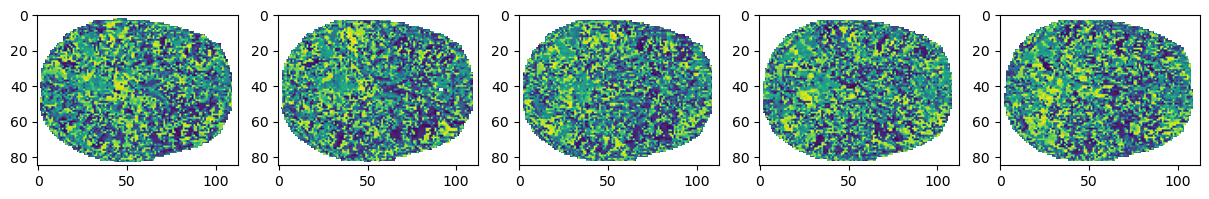

In [22]:
for i in range(5):
    # Creates a subplot in a 5x5 grid at position (i+1) 
    plt.subplot(5, 5,i + 1)
    # Displays the 2D slice of the angle_data array at depth 50+i 
    plt.imshow(angle_data[:,:,50 + i])
    # Sets the size of the entire figure to 15x15 inches
    plt.gcf().set_size_inches(15, 15)
# Displays the figure with all the subplots
plt.show()


*Description of the figure that was printed above*: 

- In the figure each voxel's value represents the polar angle of the pRF centered at that voxel.

- The map helps to get a better understanding of the retinotopic organisation of the visual cortex

- Shows how diffrent angular positions in the visual field are represented in the brain. 

Mid_slice_x is extracting a specific 2D slice from the 3D angle_data array. 

So mid_slice_x holds the polar angle data for a slice at x= 59 and includes all values along the y and z dimension. 

In [ ]:
# Just for debugging purposes, to check the shape of the mid_slice_x
# Extract a specific slice from the angle_data array at index 59

mid_slice_x = angle_data[59, :, :] 
print(mid_slice_x.shape)

(113, 83)


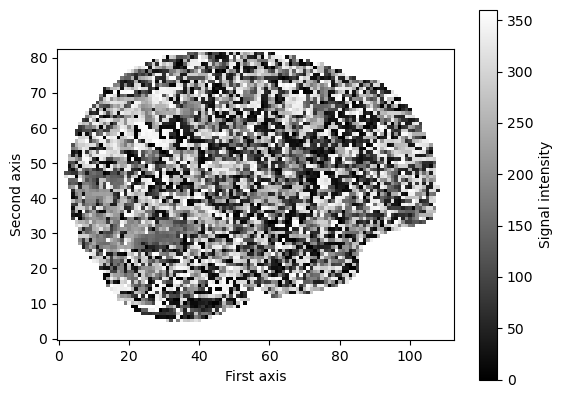

In [ ]:
# Transpose because imshow plots the first dimension on the y-axis and the
# second on the x-axis, but we'd like to plot the first on the x-axis and the second on the y-axis.

plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

# This plot shows the polar angle data in one slice 59 on the x-axis.

Further visualizations: Creation of a figure with three subplots to visualize different slices of the angle_data array along different dimensions and highlighting a specific reagion with a red rectangle in each subplot.

To visualize slices of the angle_data array along different dimensions and receive a comprehensive view of the data. 

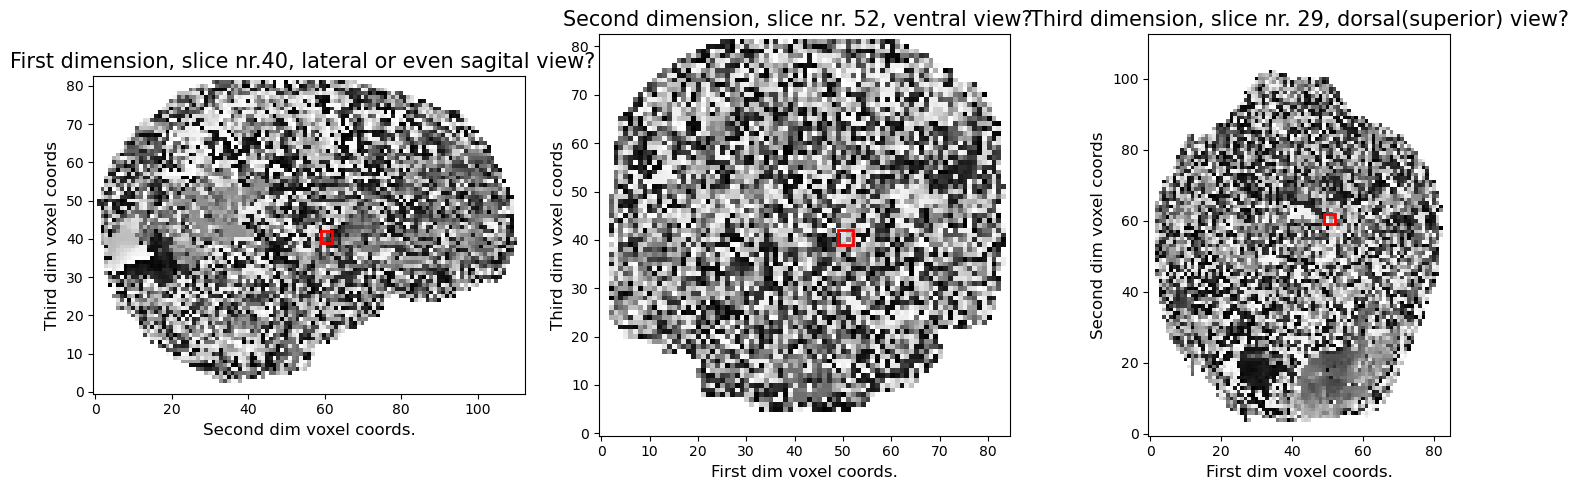

In [ ]:
# Needed to change the slice numbers compared to Hardiks notebooks because the spatial resolution
# is different in this code (func1mmpt18) = shape(81,104,32) 
# instead of if func1mm= shape(145, 186, 148)

# Creates a figure with three columns of subplots and a size of 15x5 inches
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

# Displays a 2D slice id the angle_data array at depth 40 along the first 
# dimension. The slice is transposed (.T) to switch the x and y axes as descibed above
# and displayed with a grayscale colormap 
ax[0].imshow(angle_data[39, :, :].T, origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension, slice nr.40, lateral or even sagital view?  ', fontsize=15)

# Using the value of midslice 
rect = patches.Rectangle((59, 39), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

ax[1].imshow(angle_data[:, 51, :].T, origin='lower', cmap='gray')
# Add title to the subplot

ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title('Second dimension, slice nr. 52, ventral view?  ', fontsize=15)
rect = patches.Rectangle((49, 39), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

ax[2].imshow(angle_data[:, :, 28].T, origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title('Third dimension, slice nr. 29, dorsal(superior) view?', fontsize=15)
rect = patches.Rectangle((49, 59), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)

# Adjusts the layout of the subplots to prevent overlap
fig.tight_layout()

Note from Hardiks notebook 01_PRF_single_subj.ipynb: To reduce the whole brain visualizations to the masks of interests: 

Masks of interest are : 

- `prf-visualrois` is a collection of manually drawn ROIs based on results of the prf experiment

    These ROIs consist of V1v, V1d, V2v, V2d, V3v, V3d, and hV4. 

    These ROIs extend from the fovea (0° eccentricity) to peripheral cortical regions that still exhibit sensible signals in the prf experiment given the limited stimulus size (this means up to about ~5-6° eccentricity).


Other possible masks of interest: 

1. `floc-faces`: OFA, FFA-1, FFA-2, mTL-faces ("mid temporal lobe faces"), and aTL-faces ("anterior temporal lobe faces")
2. `floc-words`: OWFA, VWFA-1, VWFA-2, mfs-words ("mid fusiform sulcus words"), and mTL-words ("mid temporal lobe words")
3. `floc-places`: OPA, PPA, and RSC
4. `floc-bodies`: EBA, FBA-1, FBA-2

Note that for the `floc-faces`, `floc-words`, and `floc-bodies` ROIs, not all subjects have all of these ROIs in every hemisphere.


Other interesting ROIs from the Wang15 Atlas as well.

# 2. Load the ROI mask from the NSD dataset 

In [26]:
def load_mask_from_nii(mask_nii_file):
    return nib.load(mask_nii_file).get_fdata()

In [27]:
# The sub_num was set at the very beginning of the notebook to 1, 
# TODO: adapt the number at the beginning of the noteboo if wished 

file_path = ROI_PATH / f'subj{sub_num:02d}/func1pt8mm/roi/prf-visualrois.nii.gz'
print(file_path)  
voxel_roi = load_mask_from_nii(file_path)

print("Shape of pRF-visual ROI mask: %s " %(voxel_roi.shape,))

# Shape of pRF-visual ROI mask with func1mm woukd be: (145, 186, 148) 
# Shape of pRF-visual ROI mask with func1mmpt8mm is: (81, 104, 83)

/gpfs01/bartels/group/nsd_dataset/nsddata/ppdata/subj06/func1pt8mm/roi/prf-visualrois.nii.gz
Shape of pRF-visual ROI mask: (85, 113, 83) 


Do the same plotting of the distinct brain slices and the marking of a specific patch with applying the brain masks to the ROIs. 

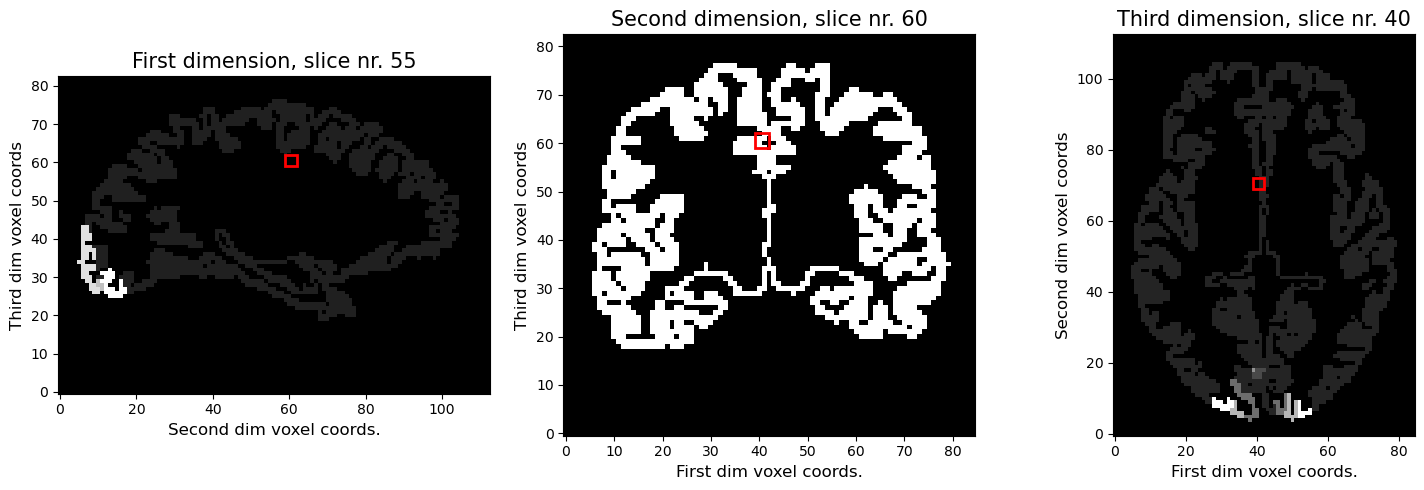

In [ ]:
# TODO: Think about deleting this part of the code. 

# Creation of a figure with three subplots arranged in a single row, ans sets the
# figure size to (15x5 inches) 
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

mask_property =  voxel_roi 

# This selects the 60th slice (index 59) along the first dimension and transposes it for 
# the display and displays the selected slice in the first subplot. 
ax[0].imshow(mask_property[54, :, :].T, origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension, slice nr. 55', fontsize=15)
# Add a rectangle to the plot to highlight the selected voxel
rect = patches.Rectangle((59, 59), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

ax[1].imshow(mask_property[:, 59, :].T, origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title('Second dimension, slice nr. 60', fontsize=15)
rect = patches.Rectangle((39, 59), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

ax[2].imshow(mask_property[:, :, 39].T, origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title('Third dimension, slice nr. 40', fontsize=15)
rect = patches.Rectangle((39, 69), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)

# Adjust the layout of the subplots to prevent overlap
fig.tight_layout()

FreeSurfer is a software package used for the analysis and visualization of structural and functional neuroimaging data from cross-sectional or longitudinal studies. 

In [29]:
# Load the measured PRF ROIS for the subjects (in this case 1)
voxel_img = image.load_img(ROI_PATH / f'subj0{sub_num}/func1mm/roi/prf-visualrois.nii.gz') 

FREESURF_PATH = NSD_DATA_ROOT / 'freesurfer/subj0{sub_num}/label'

# To be used as a background image for nilearn
t1_masked_img = image.load_img(ROI_PATH/ f'subj0{sub_num}/anat/T1_0pt5_masked.nii.gz')

# Extract the voxel data as a NumPy array
voxel_data = voxel_img.get_fdata()

# Find and return the unique values present in the voxel_data array
np.unique(voxel_data)

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.])

In [ ]:
# Same for fLoc experiment and floc faces experiment loads the data and print the unique values
voxel_img_floc_faces = image.load_img(ROI_PATH / f'subj0{sub_num}/func1mm/roi/floc-faces.nii.gz')
voxel_data_floc_faces = voxel_img_floc_faces.get_fdata()
print(np.unique(voxel_data_floc_faces))

[-1.  0.  1.  2.  3.  5.]


Copied from Hardiks code (01_pRF_single_subj.ipynb), own comments added: 

The voxels are labelled as follows: 

1. Visual ROIs
- `0`: Unknown (This indicates that the voxel's region is unknown)
- `1,2`: V1 (Dorsal and Ventral) 
- `3,4`: V2
- `5,6`: V3
- `7`:  hV4

2. floc-faces 
- `0`: Unknown
- `1`: OFA (Occipital Face Area)
- `2`: FFA-1 (Fusiform Face Area 1)
- `3`: FFA-2 (Fusiform Face Area 1)
- `4`: mTL-faces (Medial Temporal Lobe Faces)
- `5`: aTL-faces (Anterior Temporal Lobe Faces)

3. floc-bodies
- `0`: Unknown
- `1`: EBA (Extrastriate Body Area - visual perception of human bodies and body parts)
- `2`: FBA-1 (Fusiform Body Area 1)
- `3`: FBA-2 (Fusiform Body Area 2)
- `4`: mTL-bodies (Medial Temporal Lobe Bodies)

4. floc-places
- `0`: Unknown 
- `1`: OPA (Occipital Place Area, visual perception of places and scenes)
- `2`: PPA (Parahippocampal Place Area, involved in recognzing environmental scenes)
- `3`: RSC (Retrospinal Cortex, involved in spatial naviagation and scene processing)

5. floc-words
- `0`: Unknown
- `1`: OWFA (Occipital Word Form Area)
- `2`: VWFA-1 (Visual Word Form Area 1)
- `3`: VWFA-2 (Visual Word Form Area 2)
- `4`: mfs-words (Middle Fusiform Sulcus Words)
- `5`: mTL-words (Medial Temporal Lobe Words)

In [ ]:
# Create a binary mask from voxel_img: set voxels with value 1 to True (or 1), all others to False (or 0). 
# Store the result in v1_d_img.

v1_d_img = math_img("img==1",img=voxel_img)
v1_v_img = math_img("img==2",img=voxel_img)

v2_d_img = math_img("img==3",img=voxel_img)
v2_v_img = math_img("img==4",img=voxel_img)


print(np.unique(v1_d_img.get_fdata()),np.unique(v1_v_img.get_fdata()))
print(np.unique(v2_d_img.get_fdata()),np.unique(v2_v_img.get_fdata()))
print(v1_d_img.shape,v1_v_img.shape,v2_d_img.shape,v2_v_img.shape)

[0. 1.] [0. 1.]
[0. 1.] [0. 1.]
(152, 202, 148) (152, 202, 148) (152, 202, 148) (152, 202, 148)


Trying to combine ventral and dorsal masks.

In [32]:
# Using Nilearn intersect mask and taking union 
v1_mask_img = nilearn.masking.intersect_masks([v1_d_img,v1_v_img], threshold=0, connected=True)

# Using the same method as before with a logical OR 
v1_mask_m2 = math_img("np.logical_or(img==1, img==2)",img=voxel_img)

# Using another method 
v1_mask_m3 = math_img("np.logical_or(img1, img2)", img1=v1_d_img, img2=v1_v_img)

# Check if they are equal 
print(np.array_equal(v1_mask_img.get_fdata(), v1_mask_m2.get_fdata()))
print(np.array_equal(v1_mask_m2.get_fdata(), v1_mask_m3.get_fdata()))


True
True


## 2.1 Plotting of the ROI masks 

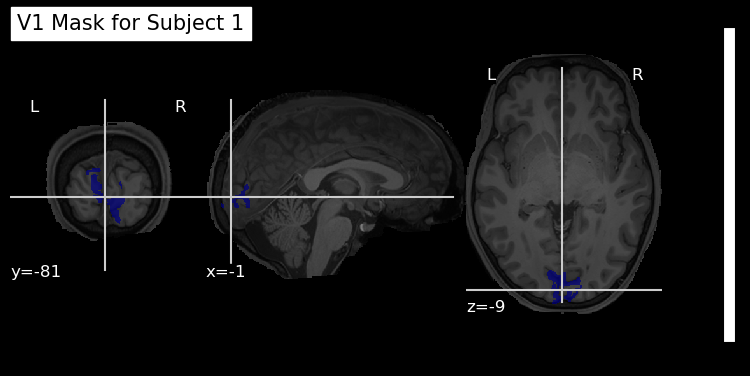

In [33]:
display = plotting.plot_roi(v1_mask_img,colorbar=True,bg_img =t1_masked_img)

# Add title to the plot specific for the sub_num
display.title(f'V1 Mask for Subject {1}')

In [34]:
display.close()

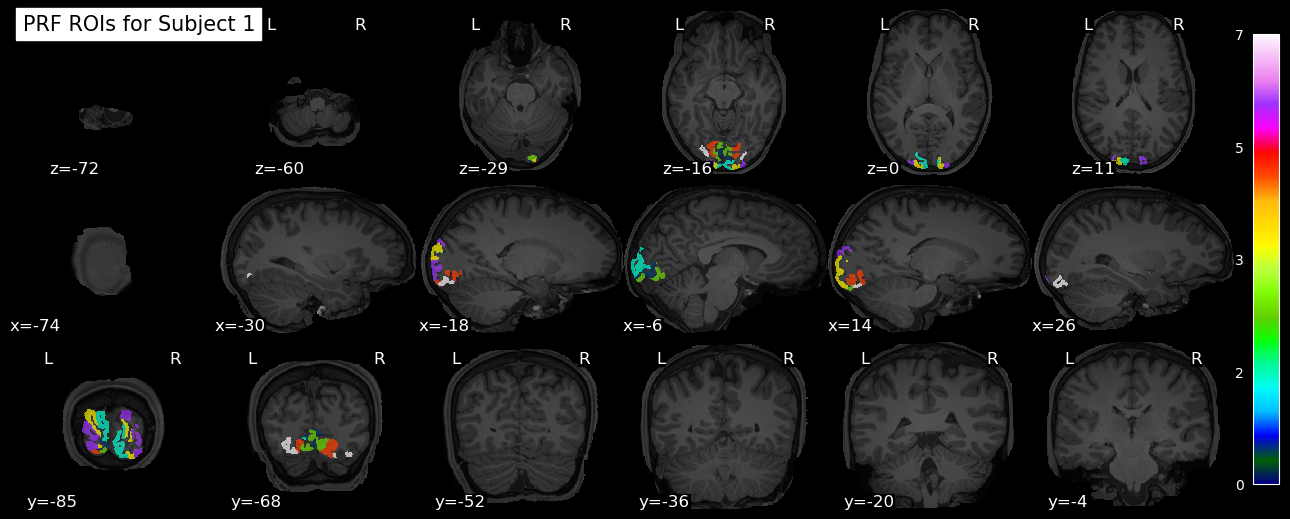

In [88]:
# The plotting.plot_roi function creates a static plot with ROIs overlaid on th t1_masked_img
display = plotting.plot_roi(voxel_img,colorbar=True,bg_img =t1_masked_img, vmin=0.5, 
                            cut_coords= 6, display_mode='mosaic')

# Add title to the plot specific for the sub_num
display.title(f'PRF ROIs for Subject {1}')

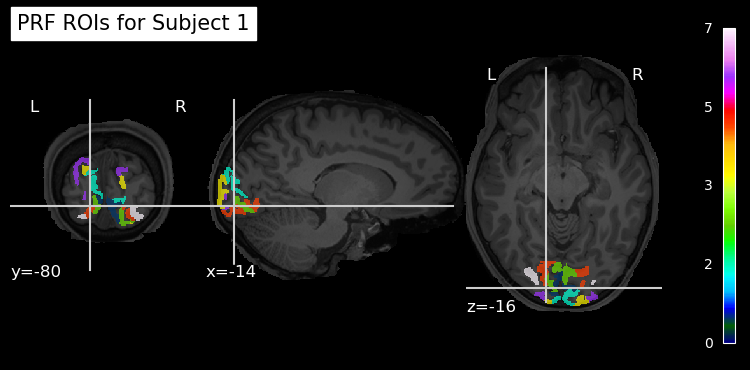

In [ ]:
# The plotting.plot_roi function creates a static plot with ROIs overlaid on th t1_masked_img
display = plotting.plot_roi(voxel_img,colorbar=True,bg_img =t1_masked_img, vmin=0.5, 
                            cut_coords= (-14,-85,-16), display_mode='ortho')

# Add title to the plot specific for the sub_num
display.title(f'PRF ROIs for Subject {1}')

In [36]:
display.close()

## 2.2 Plot that visualizes the ROIs interactively

In [ ]:
# The plotting.view_img function is used to create an interactive HTML
# View of a neuroimaging volume
# Threshold of 0.5 = indication that only values above 0.5 are displayed
plotting.view_img(voxel_img, threshold = 0.5)

# Add title to the plot specific for the sub_num
display.title(f'Interactive Visualization of the ROIs for Subject {sub_num}')

/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [ ]:
# Combine the D-V masks into single masks for V1,V2, and V3
# The logical OR operation is used to combine masks by performing a logical OR operation on the voxel values of the masks

v1_mask_img = math_img("np.logical_or(img==1, img==2)",img=voxel_img)
v2_mask_img = math_img("np.logical_or(img==3, img==4)",img=voxel_img)
v3_mask_img = math_img("np.logical_or(img==5, img==6)",img=voxel_img)
v4_mask_img = math_img("img==7",img=voxel_img)

In [39]:
# Save the images to dir, to be used later 

nib.save(v1_mask_img, '../data/v1_mask_img.nii')

nib.save(v2_mask_img, '../data/v2_mask_img.nii')

nib.save(v3_mask_img, '../data/v3_mask_img.nii')

nib.save(v4_mask_img, '../data/v4_mask_img.nii')


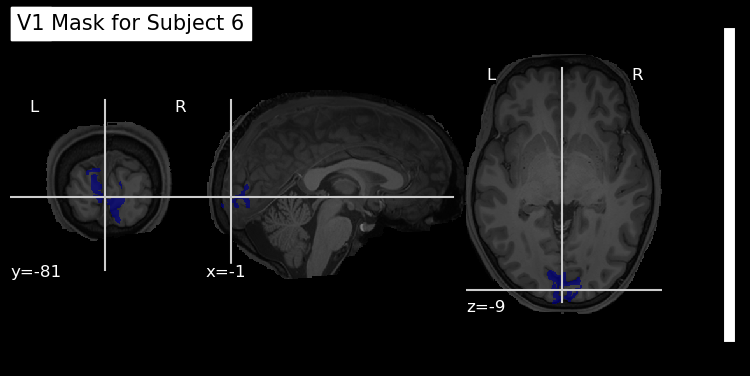

In [40]:
display = plotting.plot_roi(v1_mask_img,colorbar=True,bg_img =t1_masked_img, title = 'V1')

# Add title to the plot specific for the sub_num
display.title(f'V1 Mask for Subject {sub_num}')

In [41]:
display.close()

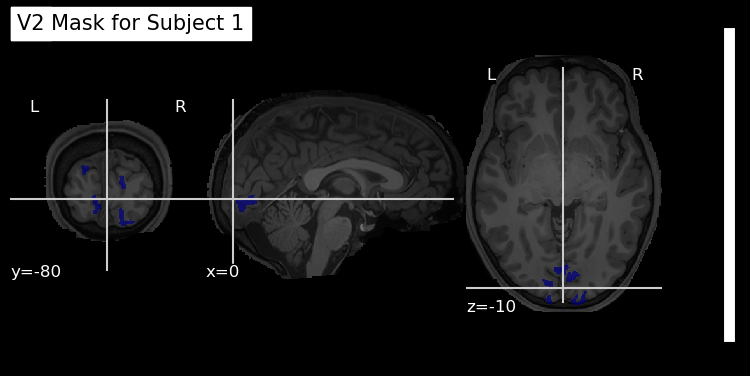

In [57]:
display = plotting.plot_roi(v2_mask_img,colorbar=True,bg_img =t1_masked_img,title = 'V2')

# Add title to the plot specific for the sub_num
display.title(f'V2 Mask for Subject {1}')

In [43]:
display.close()

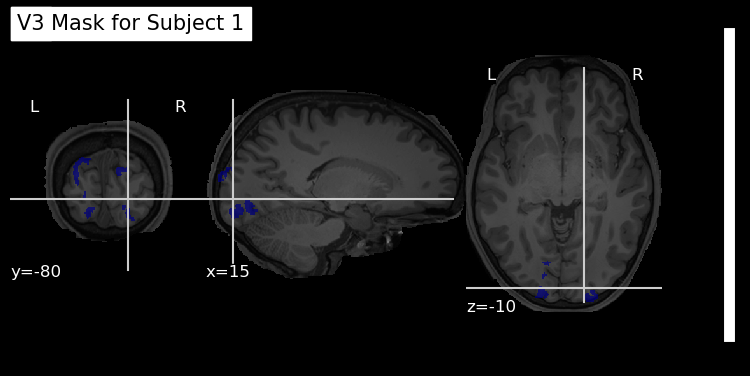

In [56]:
display = plotting.plot_roi(v3_mask_img,colorbar=True,bg_img =t1_masked_img,title = 'V3')

# Add title to the plot specific for the sub_num
display.title(f'V3 Mask for Subject {1}')

In [45]:
display.close()

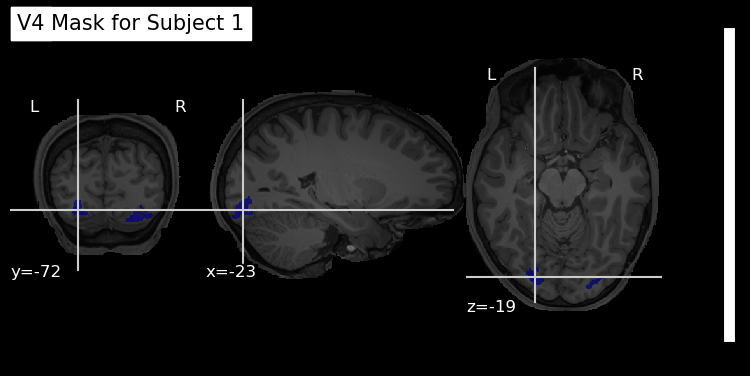

In [58]:
display = plotting.plot_roi(v4_mask_img,colorbar=True,bg_img =t1_masked_img,title = 'V4')

# Add title to the plot specific for the sub_num
display.title(f'V4 Mask for Subject {1}')

In [47]:
display.close()

# 3. Load pRF (eccentricity and angle) data and mask them with visual cortex masks

In [48]:
prf_img = {}
print(PRF_MASKS_PATH)

for file in os.listdir(PRF_MASKS_PATH):
    if file.startswith("prf"):
        
        # print(file)
        # Split the file name based on the extension and use the basename for creating new vars
        li = file.split('.')
        basename = li[0]
        # print(basename)
        filename = basename+'_imgfile'
        # filename = image.load_img(PRF_PATH,file)
        print(f"Loaded file {file}")
        # print(filename)
        
        prf_img[filename]= image.load_img(PRF_MASKS_PATH/ file)

/gpfs01/bartels/group/nsd_dataset/nsddata/ppdata/subj06/func1pt8mm
Loaded file prf_R2.nii.gz
Loaded file prf_size.nii.gz
Loaded file prf_eccentricity.nii.gz
Loaded file prf_angle.nii.gz
Loaded file prf_exponent.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_meanvol.nii.gz


In [49]:
# Print the keys of the prf_img dictionary (PRF files)
prf_img.keys()

dict_keys(['prf_R2_imgfile', 'prf_size_imgfile', 'prf_eccentricity_imgfile', 'prf_angle_imgfile', 'prf_exponent_imgfile', 'prf_gain_imgfile', 'prf_meanvol_imgfile'])

In [50]:
# Extract the prf_angle_imgfile containing the polar angles and
# eccentricity values of the receptive fields from the prf_img dictionary

angle_data = prf_img["prf_angle_imgfile"].get_fdata()


## 3.1 Apply mask to the angle data 

In [51]:
# Create NiftiMasker objects for the V1, V2, V3, and V4 masks
# using nilearn.input_data.NiftiMasker class.

v1_masker = NiftiMasker(mask_img = v1_mask_img)
v2_masker = NiftiMasker(mask_img = v2_mask_img)
v3_masker = NiftiMasker(mask_img = v3_mask_img)
v4_masker = NiftiMasker(mask_img = v4_mask_img)

## 3.2 Extracting the polar angle, eccentricity, size and R2 values from the prf_img dicitionary 

In [52]:
angle_data_v1 = v1_masker.fit_transform(prf_img["prf_angle_imgfile"])
ecc_data_v1 = v1_masker.fit_transform(prf_img["prf_eccentricity_imgfile"])
size_data_v1 = v1_masker.fit_transform(prf_img["prf_size_imgfile"])
r2_data_v1 = v1_masker.fit_transform(prf_img["prf_R2_imgfile"])

angle_data_v2 = v2_masker.fit_transform(prf_img["prf_angle_imgfile"])
ecc_data_v2 = v2_masker.fit_transform(prf_img["prf_eccentricity_imgfile"])
size_data_v2 = v2_masker.fit_transform(prf_img["prf_size_imgfile"])
r2_data_v2 = v2_masker.fit_transform(prf_img["prf_R2_imgfile"])



angle_data_v3 = v3_masker.fit_transform(prf_img["prf_angle_imgfile"])
ecc_data_v3 = v3_masker.fit_transform(prf_img["prf_eccentricity_imgfile"])
size_data_v3 = v3_masker.fit_transform(prf_img["prf_size_imgfile"])
r2_data_v3 = v3_masker.fit_transform(prf_img["prf_R2_imgfile"])


angle_data_v4 = v4_masker.fit_transform(prf_img["prf_angle_imgfile"])
ecc_data_v4 = v4_masker.fit_transform(prf_img["prf_eccentricity_imgfile"])
size_data_v4 = v4_masker.fit_transform(prf_img["prf_size_imgfile"])
r2_data_v4 = v4_masker.fit_transform(prf_img["prf_R2_imgfile"])

/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to 

# 4. Save subject-specific ROI masks to disk
- First for subject 1,2,3,4 and then for all - itratively 

#  4.1 Function defintions "save_roi_masks_to_disk" and "create_prf_imgfile_subjectwise"

- Function "save_roi_masks_to_disk" saves the ROI masks in the corresponding folder
- Function "create_prf_imgfile_subjectwise" creates a dictionary to store loaded images with dynamically created keys. 

In [62]:
# Function definition to save the ROI masks to disk in DATA_PATH 
# TODO: Add sub_num 1-8 here to generate the values 


def save_roi_masks_to_disk(sub_num): 

    # ROI Paths
    roi_path_faces = PRF_MASKS_PATH / 'roi/floc-faces.nii.gz' 
    roi_path_viz= PRF_MASKS_PATH / 'roi/prf-visualrois.nii.gz'
    roi_path_bodies = PRF_MASKS_PATH / 'roi/floc-bodies.nii.gz'
    roi_path_places = PRF_MASKS_PATH / 'roi/floc-places.nii.gz'
    roi_path_words= PRF_MASKS_PATH / 'roi/floc-words.nii.gz'
    roi_path_kastner = PRF_MASKS_PATH / 'roi/Kastner2015.nii.gz' 

    # Load the corresponding images 
    voxel_img_viz = image.load_img(roi_path_viz)
    voxel_img_faces = image.load_img(roi_path_faces)
    voxel_img_bodies = image.load_img(roi_path_bodies)
    voxel_img_places = image.load_img(roi_path_places)
    voxel_img_words = image.load_img(roi_path_words)
    voxel_img_kastner = image.load_img(roi_path_kastner)


    # Seperate the regions based on their integer labelling 
    # Combine dorsal and ventral into one mask for each ROI
    v1_mask_img = math_img("np.logical_or(img==1, img==2)",img=voxel_img_viz) 
    v2_mask_img = math_img("np.logical_or(img==3, img==4)",img=voxel_img_viz)
    v3_mask_img = math_img("np.logical_or(img==5, img==6)",img=voxel_img_viz)
    v4_mask_img = math_img("img==7",img=voxel_img_viz)

    ofa_mask_img = math_img("img == 1",img=voxel_img_faces)
    ffa1_mask_img = math_img("img == 2",img=voxel_img_faces)
    ffa2_mask_img = math_img("img == 3",img=voxel_img_faces)
    mtl_faces_mask_img = math_img("img == 4",img=voxel_img_faces)
    atl_mask_img = math_img("img == 5",img=voxel_img_faces)

    eba_mask_img = math_img("img == 1",img=voxel_img_bodies)
    fba1_mask_img = math_img("img == 2",img=voxel_img_bodies)
    fba2_mask_img = math_img("img == 3",img=voxel_img_bodies)
    mtl_bodies_mask_img = math_img("img == 4",img=voxel_img_bodies)

    opa_mask_img = math_img("img == 1",img=voxel_img_places)
    ppa_mask_img = math_img("img == 2",img=voxel_img_places)
    rsc_mask_img = math_img("img == 3",img=voxel_img_places)

    owfa_mask_img = math_img("img == 1",img=voxel_img_words)
    vwfa_1_mask_img = math_img("img == 2",img=voxel_img_words)
    vwfa_2_mask_img = math_img("img == 3",img=voxel_img_words)
    mfs_words_mask_img = math_img("img == 4",img=voxel_img_words)
    mtl_words_mask_img = math_img("img == 5",img=voxel_img_words)


    vo1_mask_img = math_img("img ==  8", img = voxel_img_kastner)
    vo2_mask_img = math_img("img ==  9", img = voxel_img_kastner)
    phc1_mask_img = math_img("img == 10", img = voxel_img_kastner)
    phc2_mask_img = math_img("img == 11", img = voxel_img_kastner)
    mst_mask_img = math_img("img ==  12", img = voxel_img_kastner)
    hmt_mask_img = math_img("img ==  13", img = voxel_img_kastner)
    lo2_mask_img = math_img("img ==  14", img = voxel_img_kastner)
    lo1_mask_img = math_img("img ==  15", img = voxel_img_kastner)
    v3b_mask_img = math_img("img ==  16", img = voxel_img_kastner)
    v3a_mask_img = math_img("img ==  17", img = voxel_img_kastner)
    ips0_mask_img = math_img("img == 18", img = voxel_img_kastner)
    ips1_mask_img = math_img("img == 19", img = voxel_img_kastner)
    ips2_mask_img = math_img("img == 20", img = voxel_img_kastner)
    ips3_mask_img = math_img("img == 21", img = voxel_img_kastner)
    ips4_mask_img = math_img("img == 22", img = voxel_img_kastner)
    ips5_mask_img = math_img("img == 23", img = voxel_img_kastner)
    spl1_mask_img = math_img("img == 24", img = voxel_img_kastner)
    fef_mask_img = math_img("img ==  25", img = voxel_img_kastner)



    mask_list = [v1_mask_img, v2_mask_img, v3_mask_img, v4_mask_img,
            ofa_mask_img,ffa1_mask_img, ffa2_mask_img, mtl_faces_mask_img, atl_mask_img,
            eba_mask_img, fba1_mask_img, fba2_mask_img, mtl_bodies_mask_img,
            opa_mask_img, ppa_mask_img, rsc_mask_img,
            owfa_mask_img, vwfa_1_mask_img,vwfa_2_mask_img , mfs_words_mask_img, mtl_words_mask_img,
                
            vo1_mask_img, vo2_mask_img , phc1_mask_img, phc2_mask_img, mst_mask_img, hmt_mask_img,lo2_mask_img, 
            lo1_mask_img, v3b_mask_img, v3a_mask_img, ips0_mask_img, ips1_mask_img,ips2_mask_img, ips3_mask_img, 
            ips4_mask_img, ips5_mask_img, spl1_mask_img, fef_mask_img] 

    
    rois = ["v1","v2","v3","v4",
           "ofa","ffa1", "ffa2","mtl_faces", "atl",
           "eba","fba1", "fba2","mtl_bodies",
           "opa", "ppa", "rsc",
           "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",

           "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
           "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
           "ips5","spl1","fef"]

    num_voxel_rois_dict = {}

    for mask, roi in zip(mask_list,rois):

        masker = NiftiMasker(mask_img = mask, standardize = True)
        try:
            # Just mask one of the pRF params to get the number of voxels
            angle_data = masker.fit_transform(prf_img["prf_angle_imgfile"])
            
        except ValueError: 
            print(f"CANNOT compute for {roi}, empty mask")
            continue # Move to next ROI 
        nib.save(mask, f"{DATA_PATH}/subjectwise_data/subject0{sub_num}/{roi}_mask_img.nii")

        # nib.save(mask, f"{DATA_PATH}/{roi}_mask_img_sub0{subject}.nii")
        print(f"Saved subject {sub_num} {roi}_mask_img.nii to disk")
        num_voxel_rois_dict[roi] = angle_data.shape[1]    
        
    with builtins.open(DATA_PATH/f'subjectwise_data/subject0{sub_num}/num_voxel_rois_dict_{sub_num}.pkl','wb') as fp:
        pickle.dump(num_voxel_rois_dict, fp)
        # Print the path to verify
        print('Dict. saved successfully', f'num_voxel_rois_dict_{sub_num}.pkl')
        # Print the path to verify


### 4.1.1 Function definition create prf_imgfile_subjectwise (subject 1-4)

To create a dictionary that stores loaded images with dynamically created keys. 

In [63]:
def create_prf_imgfile_subjectwise(sub_num: int) -> dict:

    """
    Function to load the pRF image files for a given subject and return a dictionary 
    containing the loaded image files.

    Parameters:
    -----------
    sub_num (int)
        The subject number for which the pRF image files should be loaded.

    Returns 
    -------
    prf_img (dict)
        A dictionary containing the loaded pRF image files for the given subject.
        Examples of these pRF image files are: prf_R2.nii.gz, prf_size.nii.gz,
        prf_angle.nii.gz, ...
    """

    # Initialize the dictionary to store the pRF image files
    prf_img = {}
    
    for file in os.listdir(PRF_MASKS_PATH):
        if file.startswith("prf"):

            # print(file)
            # Split the file name based on the extension and use the basename for creating new vars
            li = file.split('.')
            basename = li[0]
            # print(basename)
            filename = basename+'_imgfile'
            # filename = image.load_img(PRF_PATH,file)
            print(f"Loaded file {file}")
            # print(filename)

            prf_img[filename]= image.load_img(PRF_MASKS_PATH /file)
    return prf_img

In [ ]:
#prf_img = create_prf_imgfile_subjectwise(sub_num = 1)
#save_roi_masks_to_disk(sub_num = 1)

In [ ]:
# Function call for subject 2
#prf_img = create_prf_imgfile_subjectwise(sub_num = 2)
#save_roi_masks_to_disk(sub_num = 2)

In [ ]:
# Function call for subject 3
#prf_img = create_prf_imgfile_subjectwise(sub_num = 3)
#save_roi_masks_to_disk(sub_num = 3)

In [ ]:
# Function call for subject 4
#prf_img = create_prf_imgfile_subjectwise(sub_num = 4)
#save_roi_masks_to_disk(sub_num = 4)

### 4.1.2 Function cal: 'create_prf_imgfile_subjectwise' and 'save_roi_masks_to_disk' - For all NSD participants with applied multiprocessing  (For the rest of subjects or for all subjects at once)

In [ ]:
# Function call for entered sub_num 

# Wrapper function to handle both `create_prf_imgfile_subjectwise` and `save_roi_masks_to_disk`
def process_subject(sub_num):
    create_prf_imgfile_subjectwise(sub_num=sub_num)
    save_roi_masks_to_disk(sub_num=sub_num)

# Define the range of subjects
#sub_nums = list(range(1, 9))  # Convert range to a list, process all nsds ids 
sub_nums = list(range(5, 9)) # only process subjects 4-8, since the ROI masks for 1-4 are already created 

# Use multiprocessing to process subjects in parallel
if __name__ == "__main__":
    with Pool(processes=4) as pool:  # Adjust the number of processes as needed
        pool.map(process_subject, sub_nums)

Loaded file prf_R2.nii.gzLoaded file prf_R2.nii.gzLoaded file prf_R2.nii.gzLoaded file prf_R2.nii.gz



Loaded file prf_size.nii.gzLoaded file prf_size.nii.gz
Loaded file prf_size.nii.gz
Loaded file prf_size.nii.gz

Loaded file prf_eccentricity.nii.gzLoaded file prf_eccentricity.nii.gz
Loaded file prf_eccentricity.nii.gz

Loaded file prf_angle.nii.gzLoaded file prf_angle.nii.gz

Loaded file prf_eccentricity.nii.gz
Loaded file prf_angle.nii.gz
Loaded file prf_exponent.nii.gzLoaded file prf_exponent.nii.gz

Loaded file prf_angle.nii.gz
Loaded file prf_gain.nii.gzLoaded file prf_gain.nii.gz

Loaded file prf_exponent.nii.gz
Loaded file prf_exponent.nii.gz
Loaded file prf_meanvol.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_meanvol.nii.gz
Loaded file prf_meanvol.nii.gz
Loaded file prf_meanvol.nii.gz


/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/signal.py:74: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/signal.py:74: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/signal.py:74: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/signal.py:74: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(


Saved subject 6 v1_mask_img.nii to disk
Saved subject 8 v1_mask_img.nii to diskSaved subject 7 v1_mask_img.nii to diskSaved subject 5 v1_mask_img.nii to disk


Saved subject 8 v2_mask_img.nii to diskSaved subject 5 v2_mask_img.nii to disk

Saved subject 6 v2_mask_img.nii to diskSaved subject 7 v2_mask_img.nii to disk

Saved subject 8 v3_mask_img.nii to disk
Saved subject 5 v3_mask_img.nii to disk
Saved subject 6 v3_mask_img.nii to disk
Saved subject 7 v3_mask_img.nii to disk
Saved subject 8 v4_mask_img.nii to disk
Saved subject 5 v4_mask_img.nii to disk
Saved subject 7 v4_mask_img.nii to disk
Saved subject 6 v4_mask_img.nii to disk
Saved subject 8 ofa_mask_img.nii to diskSaved subject 7 ofa_mask_img.nii to disk

Saved subject 5 ofa_mask_img.nii to disk
Saved subject 6 ofa_mask_img.nii to disk
Saved subject 7 ffa1_mask_img.nii to diskSaved subject 8 ffa1_mask_img.nii to disk

Saved subject 5 ffa1_mask_img.nii to disk
Saved subject 6 ffa1_mask_img.nii to disk
Saved subject 8 ffa2_mask_im

### Check for missing data 

In [65]:

# load num voxel rois dict from the pickle file
with open(DATA_PATH/f'subjectwise_data/subject0{6}/num_voxel_rois_dict_{sub_num}.pkl', 'rb') as fp:
    num_voxel_rois_dict = pickle.load(fp)
# Print the loaded dictionary to verify
print(num_voxel_rois_dict)
# Print the number of voxels for each ROI
for roi, num_voxels in num_voxel_rois_dict.items():
    print(f"ROI: {roi}, Number of Voxels: {num_voxels}")


{'v1': 1127, 'v2': 1180, 'v3': 1201, 'v4': 477, 'ofa': 519, 'ffa1': 341, 'ffa2': 485, 'atl': 80, 'eba': 4126, 'fba1': 985, 'fba2': 301, 'mtl_bodies': 167, 'opa': 1362, 'ppa': 1229, 'rsc': 845, 'owfa': 522, 'vwfa_1': 612, 'vwfa_2': 539, 'mfs_words': 474, 'mtl_words': 188, 'vo1': 280, 'vo2': 415, 'phc1': 256, 'phc2': 229, 'mst': 51, 'hmt': 352, 'lo2': 251, 'lo1': 464, 'v3b': 443, 'v3a': 548, 'ips0': 674, 'ips1': 461, 'ips2': 400, 'ips3': 425, 'ips4': 100, 'ips5': 14, 'spl1': 158, 'fef': 93}
ROI: v1, Number of Voxels: 1127
ROI: v2, Number of Voxels: 1180
ROI: v3, Number of Voxels: 1201
ROI: v4, Number of Voxels: 477
ROI: ofa, Number of Voxels: 519
ROI: ffa1, Number of Voxels: 341
ROI: ffa2, Number of Voxels: 485
ROI: atl, Number of Voxels: 80
ROI: eba, Number of Voxels: 4126
ROI: fba1, Number of Voxels: 985
ROI: fba2, Number of Voxels: 301
ROI: mtl_bodies, Number of Voxels: 167
ROI: opa, Number of Voxels: 1362
ROI: ppa, Number of Voxels: 1229
ROI: rsc, Number of Voxels: 845
ROI: owfa, Num

## 5. Visualizations of the relationship between the angle_data (polar angle) and the eccentricity. 

## 5.1 Exploring the shapes of e.g. angle_data_v1 and the (amount of) unique elements in the array. 

In [ ]:
# Exploring the shapes of the angle_data and the eccentricity data of every subject 

# angle_data_v1 is an array containing the preferred orientation angles of V1 neurons

# Eccentricity refers to the distance from the center of the visual field (fovea)
#  to a point in the peripheral visual field 
# ecc_data_v1 is an array containing the eccentricity values of V1 neurons 

print(angle_data_v1.shape,ecc_data_v1.shape)
print(angle_data_v2.shape,ecc_data_v2.shape)
print(angle_data_v3.shape,ecc_data_v3.shape)
print(angle_data_v4.shape,ecc_data_v4.shape)

# This prints the amount of columns in the first row of the angle_data_v1 array
angle_data_v1[0,:].shape

(1, 6502) (1, 6502)
(1, 6309) (1, 6309)
(1, 5383) (1, 5383)
(1, 3184) (1, 3184)


(6502,)

In [ ]:
# With np.unique function: find the unique elements of an array 

# When the return_counts parameter is set to True, 
# the function also returns the number of times each unique value appears in the array.
print( np.unique(angle_data_v1, return_counts = True) )
print ( np.unique(ecc_data_v1, return_counts = True) )


(array([0.0000000e+00, 1.4716872e-03, 1.0315464e-01, ..., 3.5980725e+02,
       3.5989276e+02, 3.6000000e+02], dtype=float32), array([185,   1,   1, ...,   1,   1, 263]))
(array([0.0000000e+00, 5.8259135e-03, 8.2924133e-03, ..., 1.9196802e+01,
       2.1348433e+01, 2.8230984e+01], dtype=float32), array([302,   1,   1, ...,   1,   1,   1]))


## 5.2 Scatterplot visualizing the correlation between eccentricity values of V1, V2 and V3 and the corresponding angle values of the neurons in the ROI

In this case, the angle referes to the polar angle of the pRF center (b/w 0 and 360 degrees). 
Eccentricity represents the distance of the pRF center from the fixation point.


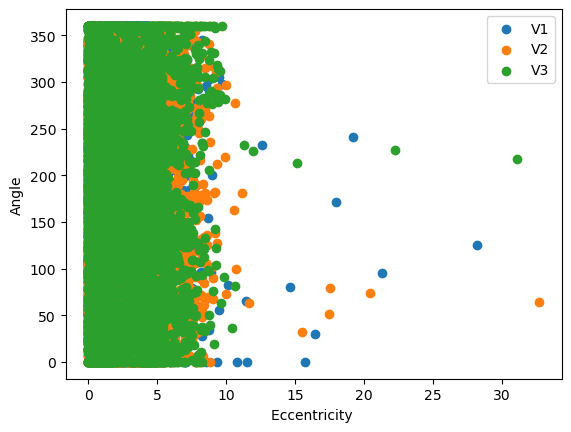

In [ ]:
x = range(0,400)
y= range(0,1100)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(ecc_data_v1[0,:],angle_data_v1[0,:], label = 'V1')
ax1.scatter(ecc_data_v2[0,:],angle_data_v2[0,:], label = 'V2')
ax1.scatter(ecc_data_v3[0,:],angle_data_v3[0,:], label = 'V3')

ax1.set_xlabel('Eccentricity ')
ax1.set_ylabel('Angle')


plt.legend()
plt.show()

The angle is sigma/sqrt(exponent)

So sigma = prfsize*sqrt(expt)

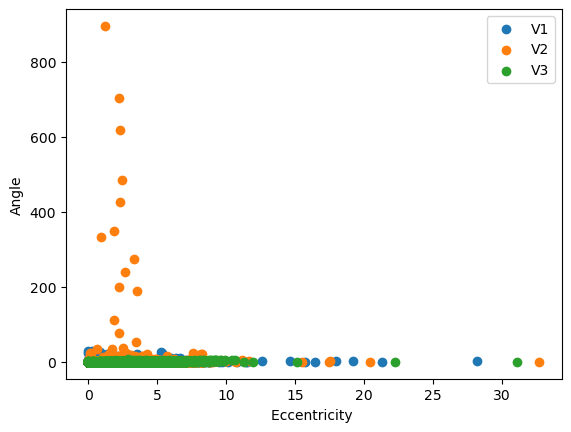

In [ ]:
# x = range(0,400)
# y= range(0,1100)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(ecc_data_v1[0,:],size_data_v1[0,:], label = 'V1')
ax1.scatter(ecc_data_v2[0,:],size_data_v2[0,:], label = 'V2')
ax1.scatter(ecc_data_v3[0,:],size_data_v3[0,:], label = 'V3')

ax1.set_xlabel('Eccentricity ')
ax1.set_ylabel('Angle')


plt.legend()
plt.show()

In [ ]:
# Convert size to sigma 

exp_data_v1 = v1_masker.fit_transform(prf_img["prf_exponent_imgfile"])
exp_data_v2 = v2_masker.fit_transform(prf_img["prf_exponent_imgfile"])
exp_data_v3 = v3_masker.fit_transform(prf_img["prf_exponent_imgfile"])
exp_data_v4 = v4_masker.fit_transform(prf_img["prf_exponent_imgfile"])

print(exp_data_v1.shape,exp_data_v2.shape,exp_data_v3.shape)

sigma_data_v1 = size_data_v1 * np.sqrt(exp_data_v1)
sigma_data_v2 = size_data_v2 * np.sqrt(exp_data_v2)
sigma_data_v3 = size_data_v3 * np.sqrt(exp_data_v3)
sigma_data_v4 = size_data_v4 * np.sqrt(exp_data_v4)

print(sigma_data_v1.shape,sigma_data_v2.shape,sigma_data_v3.shape, sigma_data_v4.shape)

/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to 

(1, 6502) (1, 6309) (1, 5383)
(1, 6502) (1, 6309) (1, 5383) (1, 3184)


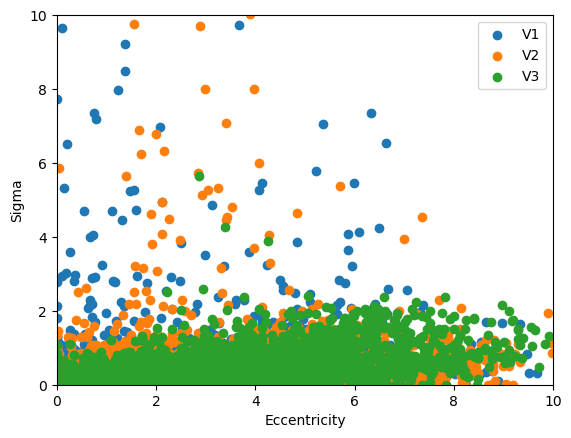

In [ ]:
# x = range(0,400)
# y= range(0,1100)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(ecc_data_v1[0,:],sigma_data_v1[0,:], label = 'V1')
ax1.scatter(ecc_data_v2[0,:],sigma_data_v2[0,:], label = 'V2')
ax1.scatter(ecc_data_v3[0,:],sigma_data_v3[0,:], label = 'V3')

ax1.set_xlabel('Eccentricity')
ax1.set_ylabel('Sigma')


ax1.set_xlim([0,10])
ax1.set_ylim([0,10])
plt.legend()
plt.show()

In [ ]:
# Bin the sigma and average across 0-1, 1-2 and so on 
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12]

digitized_sigma_v1 = np.digitize(x=ecc_data_v1, bins = bins)  # ecc 
digitized_sigma_v2 = np.digitize(x=ecc_data_v2, bins = bins) 
digitized_sigma_v3 = np.digitize(x=ecc_data_v3, bins = bins) 
digitized_sigma_v4 = np.digitize(x=ecc_data_v4, bins = bins) 



binned_sigma_v1 = [sigma_data_v1[digitized_sigma_v1 == i].mean() for i in range(1,len(bins))]
binned_sigma_v2 = [sigma_data_v2[digitized_sigma_v2 == i].mean() for i in range(1,len(bins))]
binned_sigma_v3 = [sigma_data_v3[digitized_sigma_v3 == i].mean() for i in range(1,len(bins))]
binned_sigma_v4= [sigma_data_v4[digitized_sigma_v4 == i].mean() for i in range(1,len(bins))]

In [ ]:
binned_sigma_v1

[0.20667213,
 0.19597167,
 0.2314202,
 0.3239103,
 0.39604467,
 0.76385695,
 0.8180911,
 0.5728872,
 0.5343999,
 0.7782132,
 0.09613747,
 0.005625317]

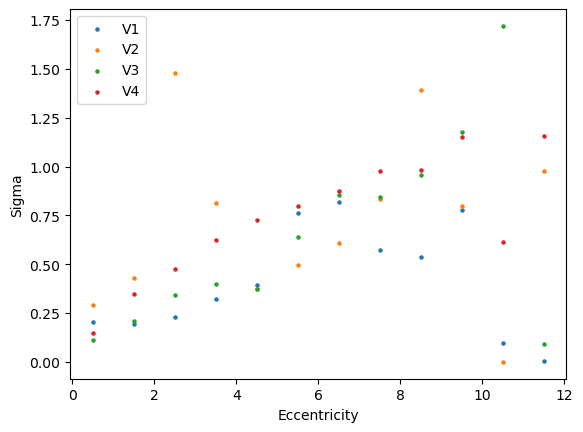

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# x = np.linspace(0,12, 12)
x = np.arange(0,12,0.5)
x = x[1::2]


# ax1.scatter(ecc_data_v1[0,:],sigma_data_v1[0,:], label = 'V1')
# ax1.scatter(ecc_data_v2[0,:],sigma_data_v2[0,:], label = 'V2')
# ax1.scatter(ecc_data_v3[0,:],sigma_data_v3[0,:], label = 'V3')
s = 5

ax1.scatter(x, binned_sigma_v1, label = 'V1',s=s)
ax1.scatter(x, binned_sigma_v2, label = 'V2',s=s)
ax1.scatter(x, binned_sigma_v3, label = 'V3',s=s)
ax1.scatter(x, binned_sigma_v4, label = 'V4',s=s)

ax1.set_xlabel('Eccentricity')
ax1.set_ylabel('Sigma')


# ax1.set_xlim([0,10])
# ax1.set_ylim([0,10])
plt.legend()
plt.show()

In [ ]:
# Function call to create a dataframe from the prf data considering the relevant parameters

def create_df_from_prfdata(vis_roi,
                           params=['angle','ecc','sigma','r2'],
                           ):
    '''
    Create a pandas dataframe given a list of pRF parameters and the ROI (V1,V2,V3,and V4) 
    '''
    
    param_names = [name+'_data'+'_'+vis_roi for name in params] # Create ['angle_data_v1', 'ecc_data_v1', 'sigma_data_v1', 'r2_data_v1']
    
    
    # Create a dataframe according to the parameter names 
    df = pd.DataFrame(data=[ globals()[param_name][0,:] for param_name in param_names])
    df = df.T
    # Renames the column names 
    df.columns = param_names
    return df
    

In [ ]:
# The dataframe of the prf parameters (angle data (polar angles, eccentricity data, sigma data ans r2 data is created
# for each ROI (V1,V2,V3, and V4))

prf_df_v1 = create_df_from_prfdata('v1')
prf_df_v2 = create_df_from_prfdata('v2')
prf_df_v3 = create_df_from_prfdata('v3')
prf_df_v4 = create_df_from_prfdata('v4')


In [ ]:
# Exemplary printing of the dataframe of prf parameters for V1
prf_df_v1

,angle_data_v1,ecc_data_v1,sigma_data_v1,r2_data_v1
0,261.180939,0.345941,0.087775,94.997849
1,314.064728,0.000000,0.193064,-457.465027
2,298.908234,0.355922,0.270227,-130.321411
3,186.335175,0.000000,0.365630,-79.843155
4,137.357101,0.116349,0.184818,94.997849
...,...,...,...,...
6497,47.604210,0.195073,0.027725,56.648273
6498,213.867371,2.092388,0.061699,73.596291
6499,218.352432,2.628424,0.000623,74.498802
6500,204.314758,1.200944,0.000000,68.162163


<Axes: xlabel='ecc_data_v1', ylabel='sigma_data_v1'>

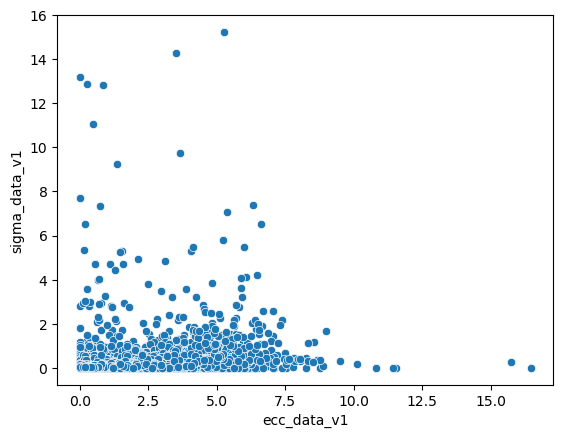

In [ ]:
sns.scatterplot(x='ecc_data_v1',y='sigma_data_v1',data=prf_df_v1.query("ecc_data_v1 < 35 & sigma_data_v1 < 20 & r2_data_v1 > 0"))
# plt.xlim(0,35)
# plt.ylim(0,20)

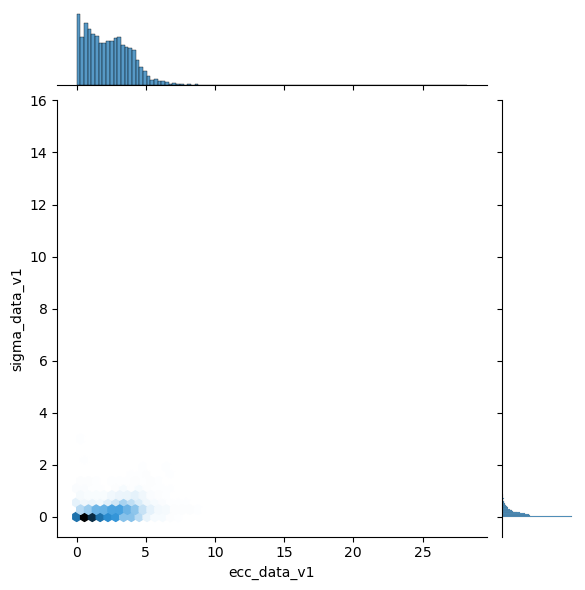

In [ ]:
# Divide the eccentricity (conditioning var) into bins and plot the conditional mean of the dependent var (sigma) 
# within each bin

s = sns.jointplot(x='ecc_data_v1',y='sigma_data_v1',
                  data=prf_df_v1.query("ecc_data_v1 < 35 & sigma_data_v1 < 20"),
                  kind = 'hex')

## 6. Function defintion load_prf_data

Function that takes in the sub_num and corresponding path for the subject and returns the prf_img dictionary containg the relevant prf files 

(such as prf_R2.nii.gz, prf_size.nii.gz, prf-Eccentricitrs.nii.gz, prf_angle.nii.gz, prf_ecponent.nii.gz, prf_gain.nii.gz and prf_meanvol.nii.gz)

In [ ]:
def load_prf_data(sub_num, path):

    prf_img = {}
    for file in os.listdir(path):
        if file.startswith("prf"):

            # print(file)
            # Split the file name based on the extension and use the basename for creating new vars
            li = file.split('.')
            basename = li[0]
            # print(basename)
            filename = basename+'_imgfile'
            # filename = image.load_img(PRF_PATH,file)
            print(f"Loaded file {file}")
            # print(filename)

            prf_img[filename]= image.load_img(path+file)
            
    return prf_img

### 6.2 Function definition "create_prf" 

Function to create the PRF for a single voxel. 

- The pRF center (x0,y0) is the voxels's preferred loaction
- Sigma (- the standard deviance) determines the PRF size (spread of the PRF kernel)
- x,y represent viual field coordinates 

Equation of a pRF: 

Population Receptive Field (pRF) Model

The pRF model describes the response of a voxel to visual stimuli. The Gaussian pRF model can be represented by the following equation:

$$
PRF(x, y) = \exp\left(-\frac{(x - x_0)^2 + (y - y_0)^2}{2\sigma^2}\right)
$$

where:
- \( R(x, y) \) is the response at position \((x, y)\)
- \( (x_0, y_0) \) is the center of the receptive field
- \( \sigma \) is the standard deviation (size) of the receptive field

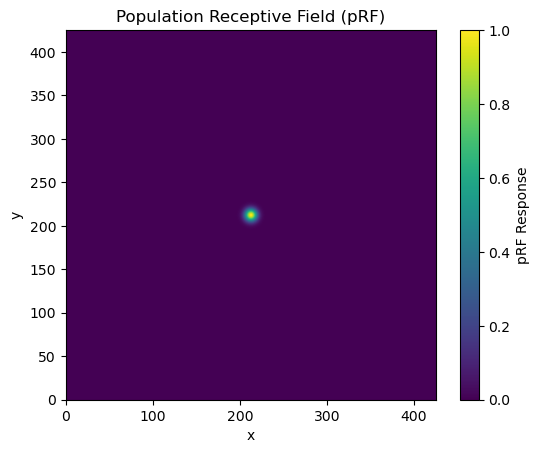

In [ ]:
# Field size is the viewing angle of the visual field, in degrees, that is visible to an observer.
# In the experiments (NSD and Eyetracking_shared1000) the field size was set to 8.4 degrees

# Field size in degrees
field_size = 8.4

# Resolution of the images
resolution = 425

# Information: The resolution of the images is originally 425x425 pixel but was in the experiments downscalded to 258x258 pixel.

# This data needs to be applied in the PRF Modeling 
angle_data_v1
ecc_data_v1
size_data_v1 
r2_data_v1

# Create a function to load the PRF for a single voxel
def create_prf(x0, y0, sigma, x_grid, y_grid):
    """
    Create the population receptive field (pRF) for a single voxel using a Gaussian model.

    Parameters
    ----------
    x0 : float
        The x-coordinate of the receptive field center.
    y0 : float
        The y-coordinate of the receptive field center.
    sigma : float
        The standard deviation (size) of the receptive field.
    x_grid : np.ndarray
        The x-coordinates of the visual field positions (2D grid).
    y_grid : np.ndarray
        The y-coordinates of the visual field positions (2D grid).

    Returns
    -------
    prf_response : np.ndarray
        The pRF response for each position in the visual field.
    """
    # Calculate the pRF response using the Gaussian model
    prf_response = np.exp(-((x_grid - x0)**2 + (y_grid - y0)**2) / (2 * sigma**2))
    
    return prf_response

betas = np.random.rand(resolution, resolution)  # Replace with actual betas data
angles = np.random.rand(resolution, resolution)  # Replace with actual angles data


# Example usage
x0 = resolution/2  # Center of the receptive field (x-coordinate)
y0 = resolution/2  # Center of the receptive field (y-coordinate)
sigma = 5  # Standard deviation (size) of the receptive field

# Create a grid of visual field positions with a resolution of 425 x 425 pixels
x = np.linspace(0, resolution, resolution)
y = np.linspace(0, resolution, resolution)
x_grid, y_grid = np.meshgrid(x, y)

# Create the pRF for the single voxel
prf_response = create_prf(x0, y0, sigma, x_grid, y_grid)

# Visualize the pRF response
plt.imshow(prf_response, extent=(0, resolution, 0, resolution), origin='lower', cmap='viridis')
plt.colorbar(label='pRF Response')
plt.title('Population Receptive Field (pRF)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Function call of the function to create the pRF for a single voxel
prf_response = create_prf(x0, y0, sigma, x_grid, y_grid)